<a href="https://colab.research.google.com/github/AKSeavey/2_Linear-Regression/blob/main/project_2_Housing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction

## Problem Definition


In order to predict the sales price of houses, this project will look at ways to minimize the root mean squared percentage error (RMSPE) in the prediction. The dataset contains various features that can be used in the regression model. This project will use regression prediction techniques, including feature scaling and regularization, to develop a model that accurately predicts house prices. This is a supervised regression problem since there is labeled data (sales prices) and the objective is to predict a continuous numerical value (house price). The challenge is to determine the optimal set of variables that effectively capture the relationship between the input features and the target variable, leading to a minimal RMSPE.

## Data Collection/Sources


In [ ]:
# load libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# point to csv file
house_path = '/content/drive/MyDrive/Colab Notebooks/project_2/Housing Data.csv'

In [ ]:
# load csv data as pandas dataframe
house_orig = pd.read_csv(house_path)

In [ ]:
# create copy of train_orig pandas dataframe
house = house_orig.copy()

In [ ]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2637 non-null   int64  
 1   MS SubClass      2637 non-null   int64  
 2   MS Zoning        2637 non-null   object 
 3   Lot Frontage     2188 non-null   float64
 4   Lot Area         2637 non-null   int64  
 5   Street           2637 non-null   object 
 6   Alley            180 non-null    object 
 7   Lot Shape        2637 non-null   object 
 8   Land Contour     2637 non-null   object 
 9   Utilities        2637 non-null   object 
 10  Lot Config       2637 non-null   object 
 11  Land Slope       2637 non-null   object 
 12  Neighborhood     2637 non-null   object 
 13  Condition 1      2637 non-null   object 
 14  Condition 2      2637 non-null   object 
 15  Bldg Type        2637 non-null   object 
 16  House Style      2637 non-null   object 
 17  Overall Qual  

In [ ]:
# smash and grab - but this time hand selected variables
cols = ["MS Zoning", "Lot Frontage", "Lot Area", "Lot Shape",
        "Land Contour", "Bldg Type", "Year Built", "Total Bsmt SF",
        "Gr Liv Area", "Full Bath", "Garage Area", "Pool Area"]
house = house[cols + ["SalePrice"]]

In [ ]:
house.head()

,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Bldg Type,Year Built,Total Bsmt SF,Gr Liv Area,Full Bath,Garage Area,Pool Area,SalePrice
0,RL,62.0,14299,Reg,Lvl,1Fam,1964,1005.0,1005,1,440.0,0,115400
1,RL,72.0,10791,Reg,Lvl,Duplex,1967,0.0,1296,2,516.0,0,90000
2,RM,50.0,9000,Reg,Bnk,1Fam,1937,780.0,1375,1,544.0,0,141000
3,FV,68.0,7379,IR1,Lvl,1Fam,2000,975.0,1848,2,592.0,0,254000
4,RL,60.0,7200,Reg,Lvl,1Fam,1936,560.0,1135,1,576.0,0,155000


## Data Overview and Cleaning


In [ ]:
house.shape

(2637, 13)

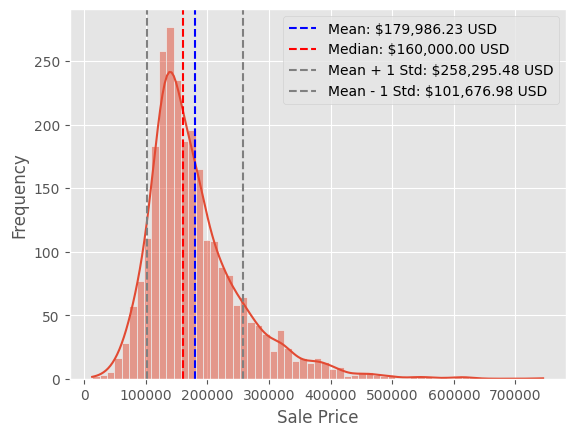

In [ ]:
# take a look at the target in more detail
sns.histplot(house['SalePrice'], kde=True)
mean = house['SalePrice'].mean()
std = house['SalePrice'].std()
median = house['SalePrice'].median()

# plt.title('Histogram of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')

plt.axvline(mean, color='blue', linestyle='--', label='Mean: $'+format(mean, ',.2f')+' USD')
plt.axvline(median, color='red', linestyle='--', label='Median: $'+format(median, ',.2f')+' USD')
plt.axvline(mean + std, color='grey', linestyle='--', label='Mean + 1 Std: $'+format(mean + std, ',.2f')+' USD')
plt.axvline(mean - std, color='grey', linestyle='--', label='Mean - 1 Std: $'+format(mean - std, ',.2f')+' USD')

plt.legend()
plt.show()

# positively skewed - indicating possible outliers in the higher range
# TEST consider box-cox or winsorization to improve model

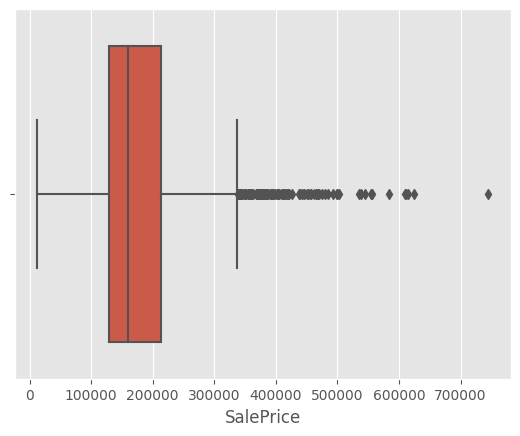

In [ ]:
sns.boxplot(x=house['SalePrice'])

plt.xlabel('SalePrice')
plt.show()

# box plot shows some outliers
# winsorization may help
# TEST different w thresholds

In [ ]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MS Zoning      2637 non-null   object 
 1   Lot Frontage   2188 non-null   float64
 2   Lot Area       2637 non-null   int64  
 3   Lot Shape      2637 non-null   object 
 4   Land Contour   2637 non-null   object 
 5   Bldg Type      2637 non-null   object 
 6   Year Built     2637 non-null   int64  
 7   Total Bsmt SF  2636 non-null   float64
 8   Gr Liv Area    2637 non-null   int64  
 9   Full Bath      2637 non-null   int64  
 10  Garage Area    2636 non-null   float64
 11  Pool Area      2637 non-null   int64  
 12  SalePrice      2637 non-null   int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 267.9+ KB


#### Lot Frontage

In [ ]:
house['Lot Frontage'].isnull().sum()

449

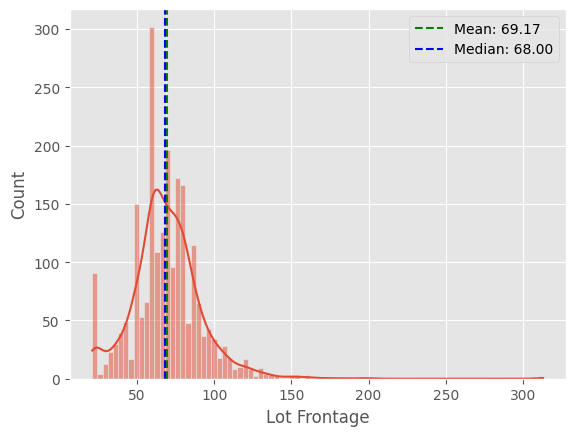

In [ ]:
# let's take a closer look at the target variable
sns.histplot(house['Lot Frontage'], kde=True)
mean = house['Lot Frontage'].mean()
std = house['Lot Frontage'].std()
median = house['Lot Frontage'].median()

plt.axvline(mean, color='green', linestyle='--', label='Mean: '+format(mean, ',.2f'))
plt.axvline(median, color='blue', linestyle='--', label='Median: '+format(median, ',.2f'))
# plt.axvline(mean + std, color='grey', linestyle='--', label='Mean + 1 Std')
# plt.axvline(mean - std, color='grey', linestyle='--', label='Mean - 1 Std')

plt.legend()
plt.show()

#maybe try RANSAC and see what it does to the model

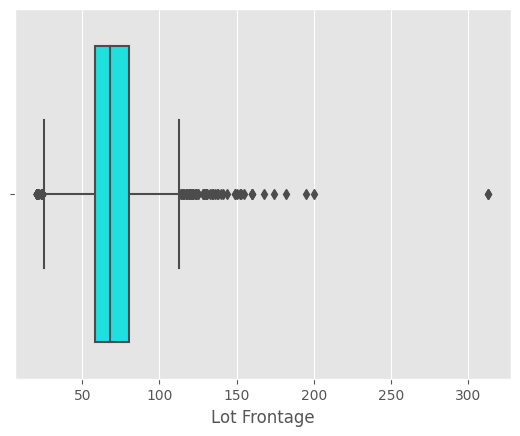

In [ ]:
# box plot to show outliers
sns.boxplot(x=house['Lot Frontage'], color = 'cyan')

plt.xlabel('Lot Frontage')
plt.show()

In [ ]:
# fill missing values in lot fronage w/ lot frontage average
house_clean = house.copy()
house_clean['Lot Frontage'].fillna(house_clean['Lot Frontage'].mean(), inplace = True)

In [ ]:
house_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MS Zoning      2637 non-null   object 
 1   Lot Frontage   2637 non-null   float64
 2   Lot Area       2637 non-null   int64  
 3   Lot Shape      2637 non-null   object 
 4   Land Contour   2637 non-null   object 
 5   Bldg Type      2637 non-null   object 
 6   Year Built     2637 non-null   int64  
 7   Total Bsmt SF  2636 non-null   float64
 8   Gr Liv Area    2637 non-null   int64  
 9   Full Bath      2637 non-null   int64  
 10  Garage Area    2636 non-null   float64
 11  Pool Area      2637 non-null   int64  
 12  SalePrice      2637 non-null   int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 267.9+ KB


#### Total Bsmt SF

In [ ]:
# one NaN, will fill with a 0
house['Total Bsmt SF'].mean()

1045.1790591805766

In [ ]:
house[house['Total Bsmt SF'].isnull()]

,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Bldg Type,Year Built,Total Bsmt SF,Gr Liv Area,Full Bath,Garage Area,Pool Area,SalePrice
847,RM,99.0,5940,IR1,Lvl,1Fam,1946,NaN,896,1,280.0,0,79000


In [ ]:
house_clean['Total Bsmt SF'].fillna(0, inplace=True)

#### Garage Area

In [ ]:
# one NaN, will fill with a 0
house['Garage Area'].value_counts()

0.0      145
576.0     91
440.0     89
484.0     71
240.0     59
        ... 
162.0      1
662.0      1
682.0      1
455.0      1
207.0      1
Name: Garage Area, Length: 576, dtype: int64

In [ ]:
house[house['Garage Area'].isnull()]

,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Bldg Type,Year Built,Total Bsmt SF,Gr Liv Area,Full Bath,Garage Area,Pool Area,SalePrice
329,RM,50.0,9060,Reg,Lvl,1Fam,1923,859.0,1828,2,NaN,0,150909


In [ ]:
house_clean['Garage Area'].fillna(0, inplace=True)

In [ ]:
house_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MS Zoning      2637 non-null   object 
 1   Lot Frontage   2637 non-null   float64
 2   Lot Area       2637 non-null   int64  
 3   Lot Shape      2637 non-null   object 
 4   Land Contour   2637 non-null   object 
 5   Bldg Type      2637 non-null   object 
 6   Year Built     2637 non-null   int64  
 7   Total Bsmt SF  2637 non-null   float64
 8   Gr Liv Area    2637 non-null   int64  
 9   Full Bath      2637 non-null   int64  
 10  Garage Area    2637 non-null   float64
 11  Pool Area      2637 non-null   int64  
 12  SalePrice      2637 non-null   int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 267.9+ KB


#### Get Dummies

In [ ]:
# one-hot encoding for categorical data
categorical_columns = ["MS Zoning", "Land Contour", "Bldg Type"]

for column in categorical_columns:
    dum_house_clean = pd.get_dummies(house_clean[column], prefix=column)
    house_clean = pd.concat([house_clean, dum_house_clean], axis=1)

house_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS Zoning          2637 non-null   object 
 1   Lot Frontage       2637 non-null   float64
 2   Lot Area           2637 non-null   int64  
 3   Lot Shape          2637 non-null   object 
 4   Land Contour       2637 non-null   object 
 5   Bldg Type          2637 non-null   object 
 6   Year Built         2637 non-null   int64  
 7   Total Bsmt SF      2637 non-null   float64
 8   Gr Liv Area        2637 non-null   int64  
 9   Full Bath          2637 non-null   int64  
 10  Garage Area        2637 non-null   float64
 11  Pool Area          2637 non-null   int64  
 12  SalePrice          2637 non-null   int64  
 13  MS Zoning_A (agr)  2637 non-null   uint8  
 14  MS Zoning_C (all)  2637 non-null   uint8  
 15  MS Zoning_FV       2637 non-null   uint8  
 16  MS Zoning_I (all)  2637 

In [ ]:
house_clean = house_clean.drop(["MS Zoning", "Land Contour", "Bldg Type"], axis=1)

In [ ]:
house_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Lot Frontage       2637 non-null   float64
 1   Lot Area           2637 non-null   int64  
 2   Lot Shape          2637 non-null   object 
 3   Year Built         2637 non-null   int64  
 4   Total Bsmt SF      2637 non-null   float64
 5   Gr Liv Area        2637 non-null   int64  
 6   Full Bath          2637 non-null   int64  
 7   Garage Area        2637 non-null   float64
 8   Pool Area          2637 non-null   int64  
 9   SalePrice          2637 non-null   int64  
 10  MS Zoning_A (agr)  2637 non-null   uint8  
 11  MS Zoning_C (all)  2637 non-null   uint8  
 12  MS Zoning_FV       2637 non-null   uint8  
 13  MS Zoning_I (all)  2637 non-null   uint8  
 14  MS Zoning_RH       2637 non-null   uint8  
 15  MS Zoning_RL       2637 non-null   uint8  
 16  MS Zoning_RM       2637 

#### Ordinal Encoding

In [ ]:
# trying the label technique for this ordinal data
ordinal_column = 'Lot Shape'

ordinal_mapping = {
    'Reg': 1,
    'IR1': 2,
    'IR2': 3,
    'IR3': 4
}

house_clean[ordinal_column] = house_clean[ordinal_column].map(ordinal_mapping)

In [ ]:
house_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Lot Frontage       2637 non-null   float64
 1   Lot Area           2637 non-null   int64  
 2   Lot Shape          2637 non-null   int64  
 3   Year Built         2637 non-null   int64  
 4   Total Bsmt SF      2637 non-null   float64
 5   Gr Liv Area        2637 non-null   int64  
 6   Full Bath          2637 non-null   int64  
 7   Garage Area        2637 non-null   float64
 8   Pool Area          2637 non-null   int64  
 9   SalePrice          2637 non-null   int64  
 10  MS Zoning_A (agr)  2637 non-null   uint8  
 11  MS Zoning_C (all)  2637 non-null   uint8  
 12  MS Zoning_FV       2637 non-null   uint8  
 13  MS Zoning_I (all)  2637 non-null   uint8  
 14  MS Zoning_RH       2637 non-null   uint8  
 15  MS Zoning_RL       2637 non-null   uint8  
 16  MS Zoning_RM       2637 

In [ ]:
house_clean['Lot Shape'].value_counts()

1    1662
2     895
3      65
4      15
Name: Lot Shape, dtype: int64

## Exploratory Data Analysis


In [ ]:
# individual histograms
# List of numerical variables
numerical_columns = ['SalePrice', 'Lot Frontage', 'Lot Area', 'Year Built', 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'Pool Area']

# Create a single plot for overlaying histograms and KDE plots
# plt.figure(figsize=(10, 6))

# Iterate over the numerical columns
# for column in numerical_columns:
    # Plot histogram
#    sns.histplot(data=house_clean, x=column, kde=True, stat="density", label=column)

    # Plot KDE plot
#    sns.kdeplot(data=house_clean, x=column)

# Set title for the plot
# plt.title("Numerical Variables Overlay")

# Add legend
# plt.legend()

# Show the plot
# plt.show()


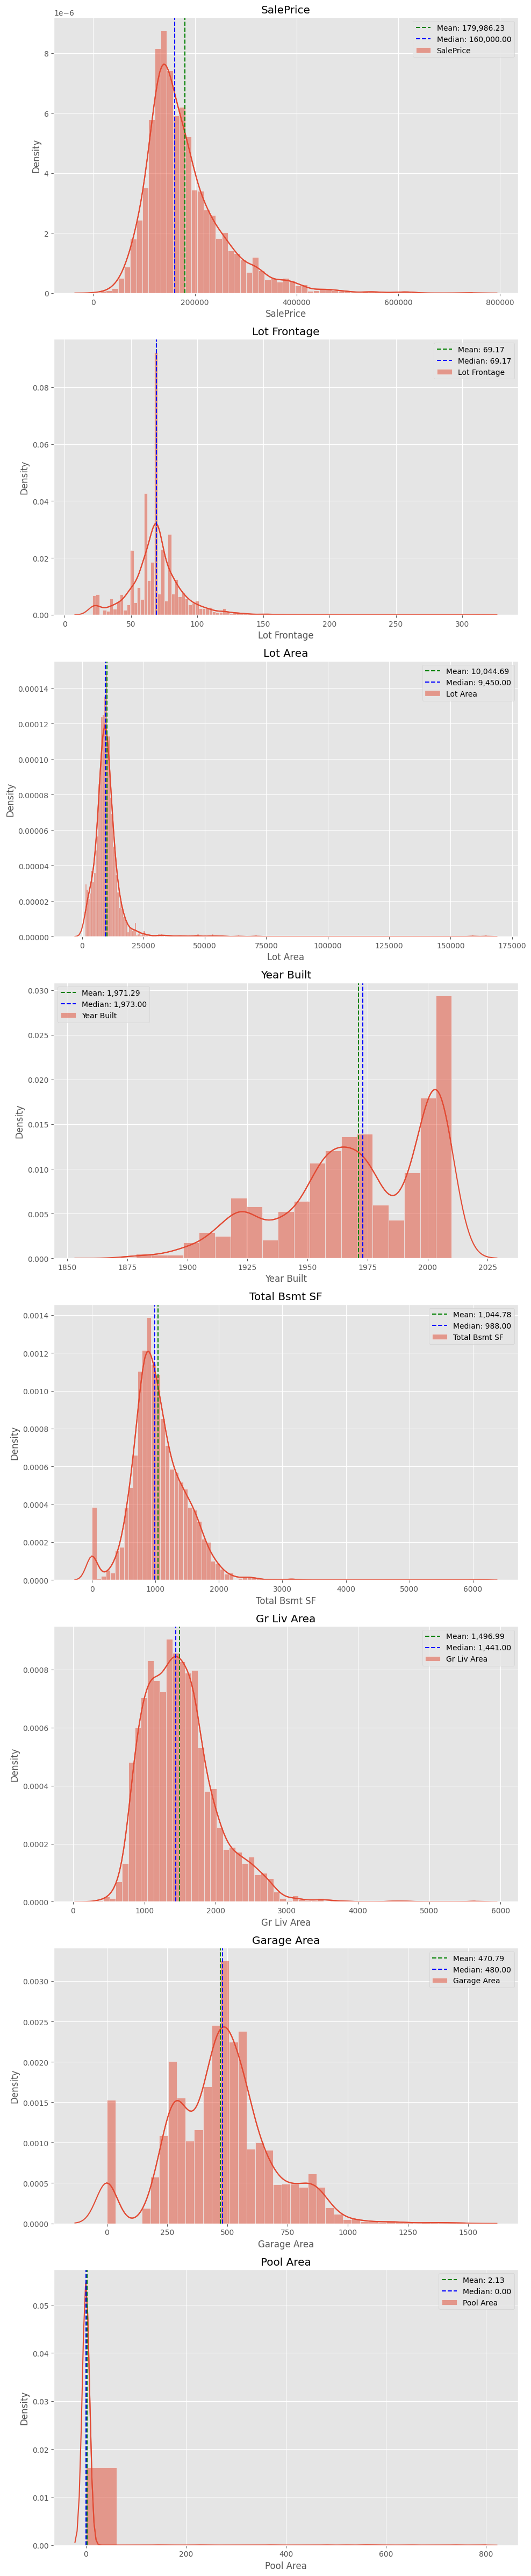

In [ ]:
# Create subplots for the histograms
fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(10, 6 * len(numerical_columns)))

# Iterate over the numerical columns
for i, column in enumerate(numerical_columns):
    # Plot histogram
    sns.histplot(data=house_clean, x=column, kde=True, stat="density", ax=axes[i], label=column)

    # Plot KDE plot
    sns.kdeplot(data=house_clean, x=column, ax=axes[i])

    # Calculate mean, median, and standard deviation
    mean = house_clean[column].mean()
    median = house_clean[column].median()
    std = house_clean[column].std()

    # Add mean and median lines
    axes[i].axvline(mean, color='green', linestyle='--', label='Mean: '+format(mean, ',.2f'))
    axes[i].axvline(median, color='blue', linestyle='--', label='Median: '+format(median, ',.2f'))

    # Set title for each subplot
    axes[i].set_title(column)

    # Add legend
    axes[i].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

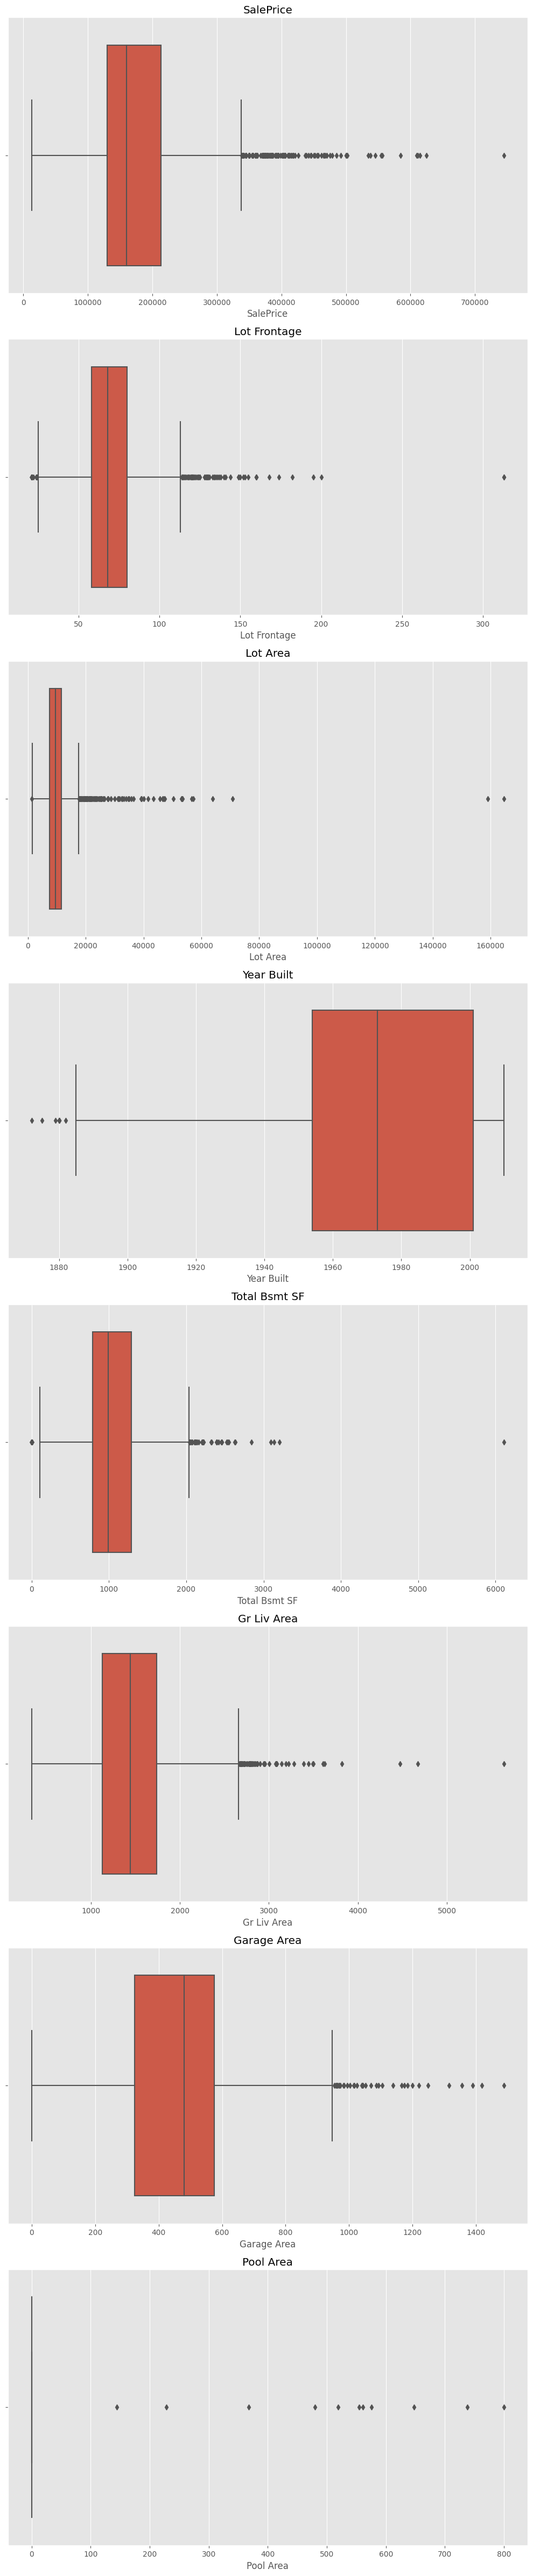

In [ ]:
# Create subplots for the histograms
fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(10, 6 * len(numerical_columns)))

# Iterate over the numerical columns
for i, column in enumerate(numerical_columns):

    sns.boxplot(x=house[column], ax=axes[i])
    axes[i].set_xlabel(column)

    # Set title for each subplot
    axes[i].set_title(column)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



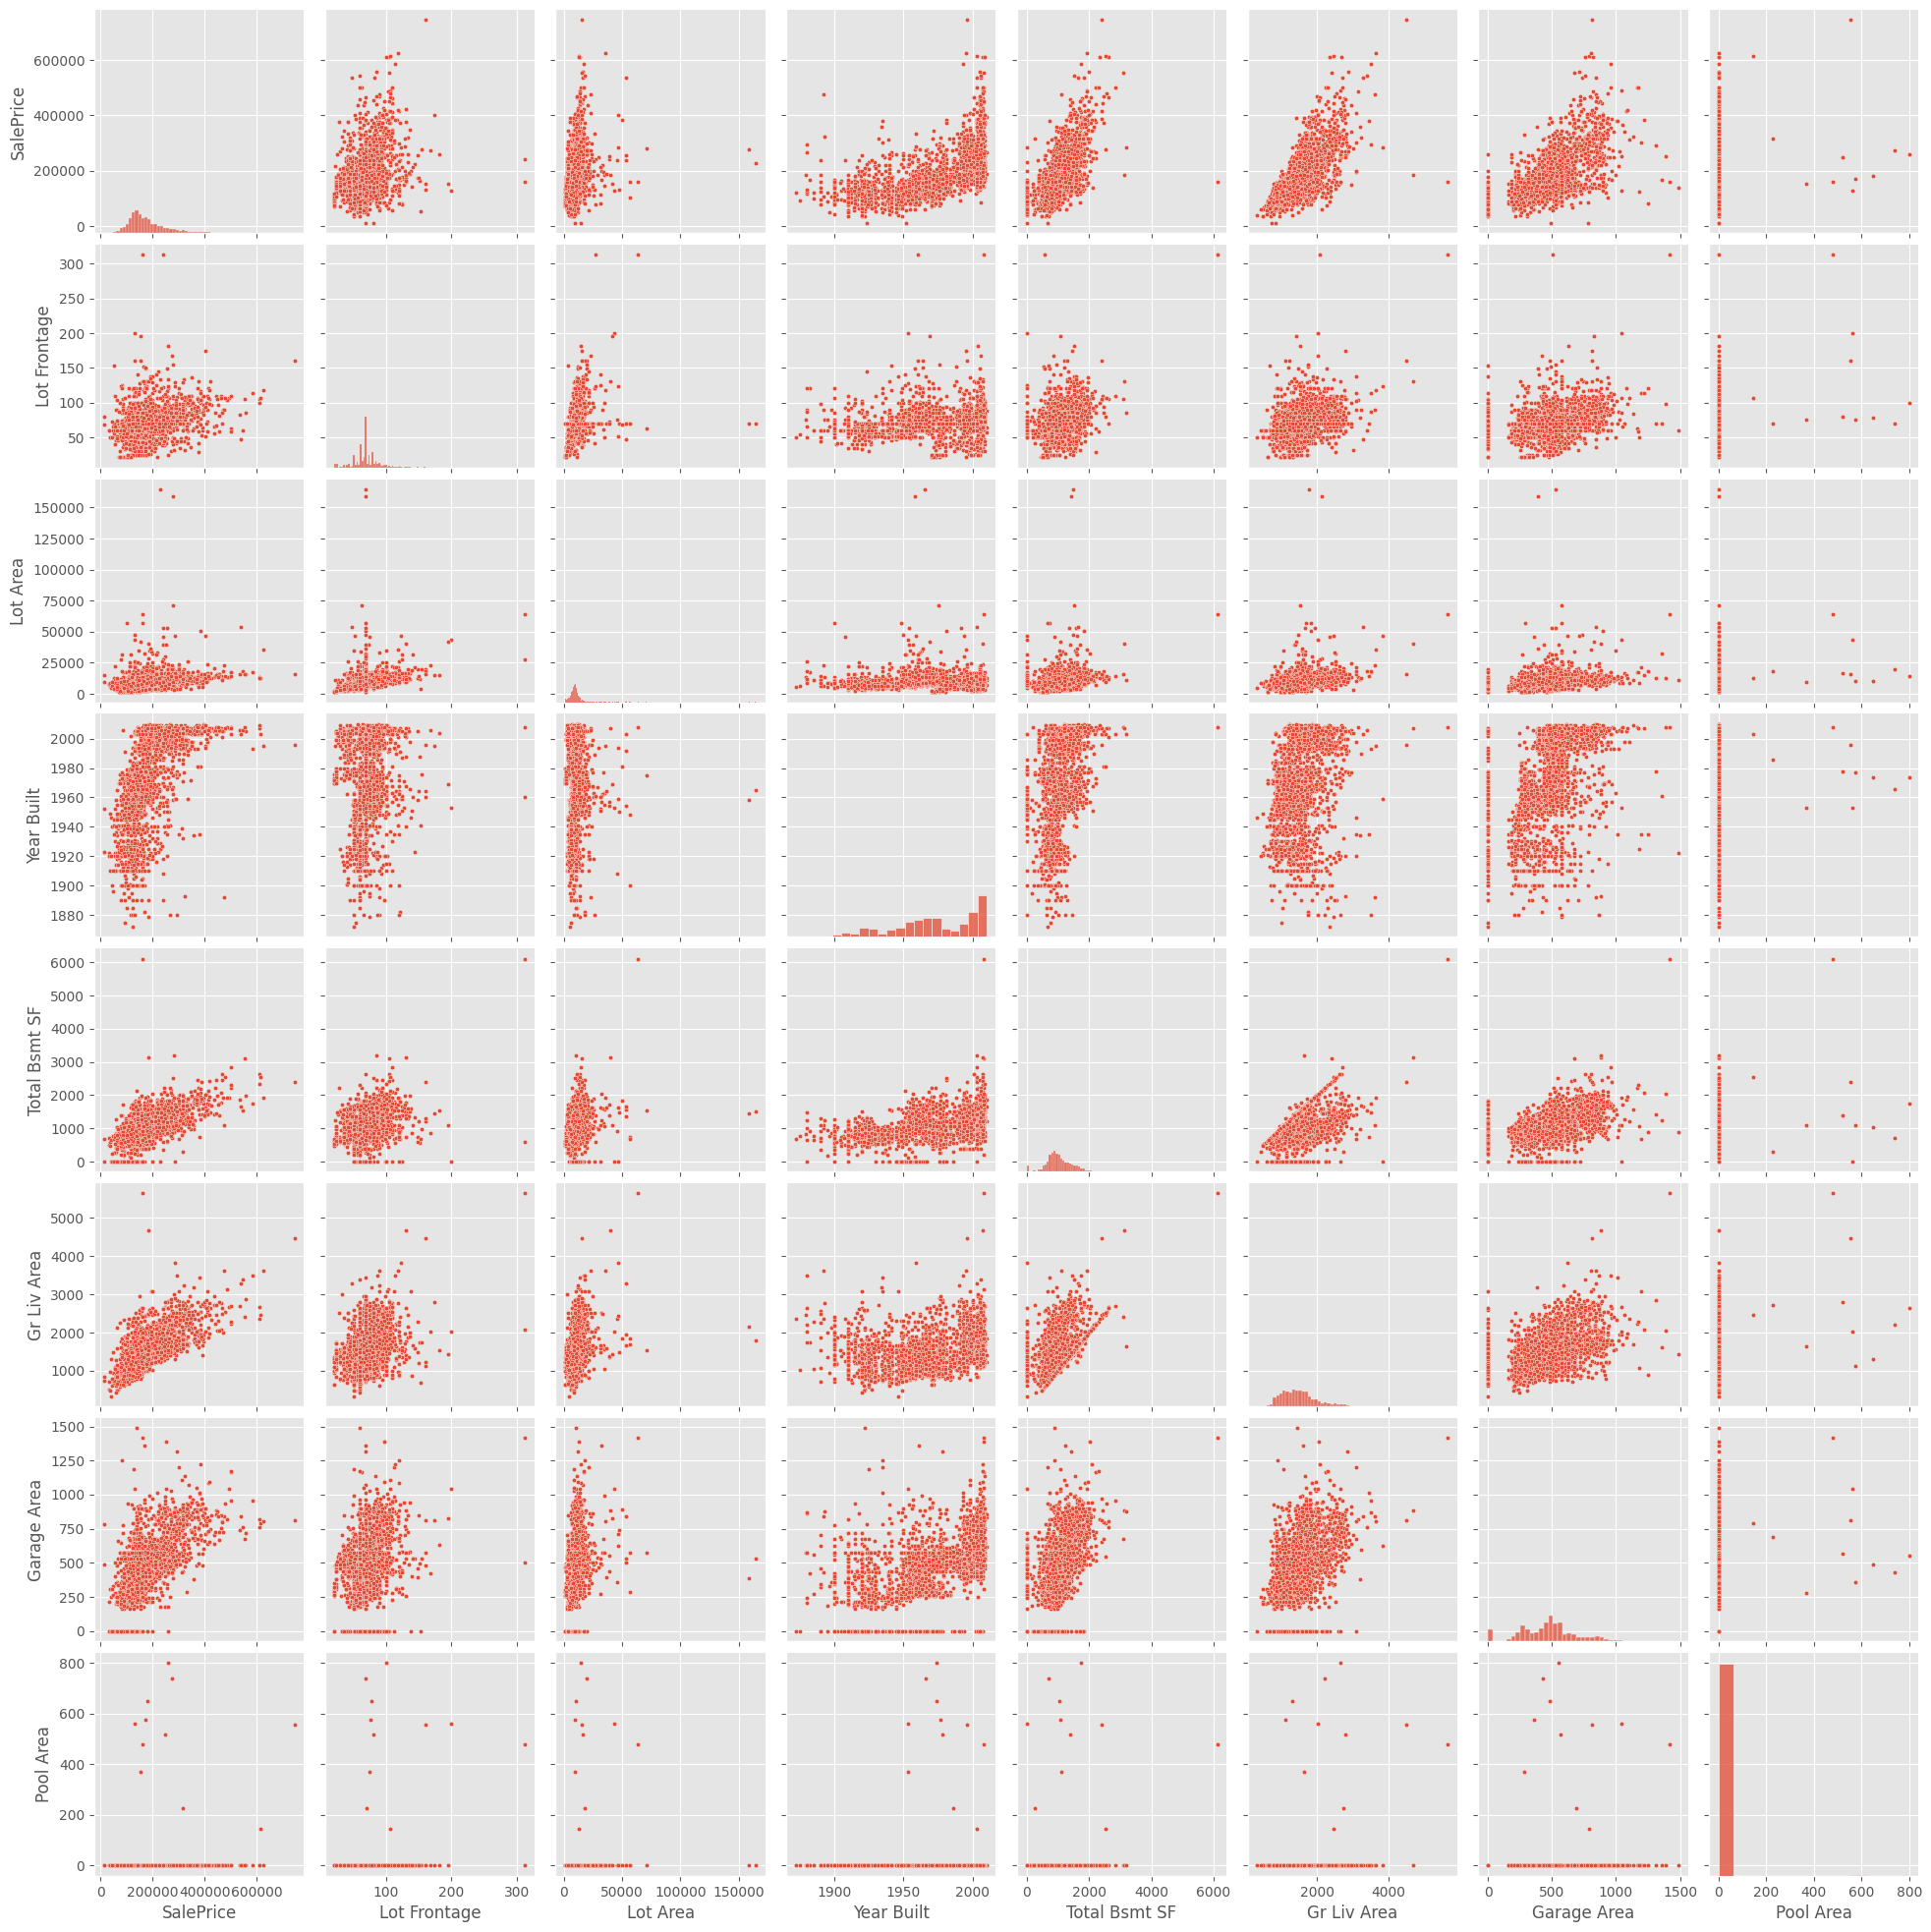

In [ ]:
# Create  pairplot with color
sns.pairplot(house_clean[numerical_columns], plot_kws={'s': 10})

# Display the plot
plt.show()

In [ ]:
# plot correlation matrix of sample_1
correlation_matrix = house_clean.corr(numeric_only=True)
# correlation_matrix = house_clean[numerical_columns].corr(numeric_only=True)
plt.figure(figsize=(17,11))
sns.heatmap(correlation_matrix, annot=True, cmap='magma')
plt.title('correlation matrix')
plt.show()

# try abs value

In [ ]:
corrs = house_clean.corr().round(2).unstack().abs()
corrs = corrs[corrs<1]
corrs.sort_values(ascending=False)

MS Zoning_RL       MS Zoning_RM         0.81
MS Zoning_RM       MS Zoning_RL         0.81
Gr Liv Area        SalePrice            0.71
SalePrice          Gr Liv Area          0.71
Bldg Type_TwnhsE   Bldg Type_1Fam       0.65
                                        ... 
Land Contour_Lvl   MS Zoning_RM         0.00
MS Zoning_A (agr)  MS Zoning_I (all)    0.00
                   MS Zoning_C (all)    0.00
Bldg Type_Twnhs    MS Zoning_RH         0.00
Bldg Type_2fmCon   MS Zoning_A (agr)    0.00
Length: 650, dtype: float64

## Processing


In [ ]:
print(house_clean.columns)

Index(['Lot Frontage', 'Lot Area', 'Lot Shape', 'Year Built', 'Total Bsmt SF',
       'Gr Liv Area', 'Full Bath', 'Garage Area', 'Pool Area', 'SalePrice',
       'MS Zoning_A (agr)', 'MS Zoning_C (all)', 'MS Zoning_FV',
       'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM',
       'Land Contour_Bnk', 'Land Contour_HLS', 'Land Contour_Low',
       'Land Contour_Lvl', 'Bldg Type_1Fam', 'Bldg Type_2fmCon',
       'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'Bldg Type_TwnhsE'],
      dtype='object')


In [ ]:
# fit the linear regression model
X = house_clean[['Lot Frontage', 'Lot Area', 'Lot Shape', 'Year Built', 'Total Bsmt SF',
       'Gr Liv Area', 'Full Bath', 'Garage Area', 'Pool Area',
       'MS Zoning_A (agr)', 'MS Zoning_C (all)', 'MS Zoning_FV',
       'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM',
       'Land Contour_Bnk', 'Land Contour_HLS', 'Land Contour_Low',
       'Land Contour_Lvl', 'Bldg Type_1Fam', 'Bldg Type_2fmCon',
       'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'Bldg Type_TwnhsE']]
X2 = sm.add_constant(X)
print(X2.head())

y=house_clean['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=4)

In [ ]:
myfit = sm.OLS(y_train, X_train).fit()
myfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     295.2
Date:                Fri, 16 Jun 2023   Prob (F-statistic):               0.00
Time:                        06:52:23   Log-Likelihood:                -25260.
No. Observations:                2109   AIC:                         5.057e+04
Df Residuals:                    2086   BIC:                         5.070e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -8.579e+05   5.23e+04    -16.401      0.000    -9.6e+05   -7.55e+05
Lot Frontage         25.0372     52.881      0.473      0.636     -78.668     128.742
Lot Area             -0.0836      0.168     -0.499      0.618      -0.412       0.245
Lot Shape           972.7859   1662.691      0.585      0.559   -2287.920    4233.492
Year Built          685.5900     43.247     15.853      0.000     600.777     770.403
Total Bsmt SF        39.8134      2.424     16.425      0.000      35.060      44.567
Gr Liv Area          74.2677      2.556     29.056      0.000      69.255      79.280
Full Bath           133.4509   2233.819      0.060      0.952   -4247.295    4514.197
Garage Area          55.7973      5.253     10.621      0.000      45.495      66.099
Pool Area           -59.9232     22.127     -2.708      0.007    -103.317     -16.529
MS Zoning_A (agr) -1.764e+05   3.54e+04     -4.979      0.000   -2.46e+05   -1.07e+05
MS Zoning_C (all) -1.269e+05   1.29e+04     -9.856      0.000   -1.52e+05   -1.02e+05
MS Zoning_FV      -1.092e+05   1.19e+04     -9.196      0.000   -1.32e+05   -8.59e+04
MS Zoning_I (all) -9.156e+04   3.49e+04     -2.626      0.009    -1.6e+05   -2.32e+04
MS Zoning_RH      -1.253e+05   1.37e+04     -9.180      0.000   -1.52e+05   -9.86e+04
MS Zoning_RL      -1.138e+05   1.11e+04    -10.250      0.000   -1.36e+05   -9.21e+04
MS Zoning_RM      -1.147e+05   1.04e+04    -11.014      0.000   -1.35e+05   -9.43e+04
Land Contour_Bnk  -2.305e+05   1.32e+04    -17.481      0.000   -2.56e+05   -2.05e+05
Land Contour_HLS  -1.864e+05   1.37e+04    -13.633      0.000   -2.13e+05    -1.6e+05
Land Contour_Low  -2.176e+05   1.43e+04    -15.180      0.000   -2.46e+05   -1.89e+05
Land Contour_Lvl  -2.234e+05   1.33e+04    -16.765      0.000    -2.5e+05   -1.97e+05
Bldg Type_1Fam    -1.568e+05   1.03e+04    -15.164      0.000   -1.77e+05   -1.37e+05
Bldg Type_2fmCon  -1.657e+05   1.08e+04    -15.377      0.000   -1.87e+05   -1.45e+05
Bldg Type_Duplex  -2.008e+05   1.08e+04    -18.613      0.000   -2.22e+05    -1.8e+05
Bldg Type_Twnhs   -1.754e+05   1.22e+04    -14.391      0.000   -1.99e+05   -1.51e+05
Bldg Type_TwnhsE  -1.592e+05   1.16e+04    -13.729      0.000   -1.82e+05   -1.36e+05
==============================================================================
Omnibus:                      798.873   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90998.186
Skew:                          -0.770   Prob(JB):                         0.00
Kurtosis:                      35.143   Cond. No.                     1.12e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smalles

In [ ]:
X = house_clean[['Lot Frontage', 'Lot Area', 'Lot Shape', 'Year Built', 'Total Bsmt SF',
       'Gr Liv Area', 'Full Bath', 'Garage Area', 'Pool Area',
       'MS Zoning_A (agr)', 'MS Zoning_C (all)', 'MS Zoning_FV',
       'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM',
       'Land Contour_Bnk', 'Land Contour_HLS', 'Land Contour_Low',
       'Land Contour_Lvl', 'Bldg Type_1Fam', 'Bldg Type_2fmCon',
       'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'Bldg Type_TwnhsE']]
y = house_clean['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)

In [ ]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Ridge()

In [ ]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'Predicted Sale Price')

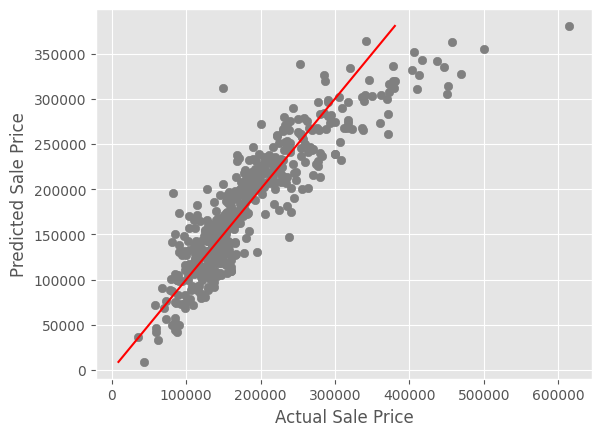

In [ ]:
plt.scatter(y_test, y_pred, c='grey')
plt.plot([min(y_pred), max(y_pred)],[min(y_pred), max(y_pred)], c='red')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

In [ ]:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [ 2.48826788e+01 -8.01113069e-02  1.00697411e+03  6.85933298e+02
  3.98844601e+01  7.42720327e+01  1.10157275e+02  5.57582143e+01
 -5.98687915e+01 -2.75484682e+04 -6.04281616e+03  1.12325056e+04
  1.44885456e+04 -4.57925998e+03  6.63611900e+03  5.81337414e+03
 -1.56834747e+04  2.79517198e+04 -3.60315147e+03 -8.66509360e+03
  1.46845956e+04  5.63496285e+03 -2.88664157e+04 -3.75114768e+03
  1.22980049e+04]
Intercept: -1365361.3588094737


In [ ]:
list(zip(y_test,y_pred))[:10]

[(247000, 219296.88564594835),
 (135000, 99560.36603244138),
 (165000, 140851.40188471624),
 (127500, 149786.88813147997),
 (105000, 78507.69329608837),
 (100000, 127468.0996331363),
 (201800, 194969.14432033175),
 (235128, 253169.57554058614),
 (155000, 155418.28968105302),
 (104000, 156605.23551257118)]

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared = False)
print(f"RMSE: {rmse}")

RMSE: 35925.453863189665


In [ ]:
results = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv = 10)
rmse = abs(results.mean())
print(f"CV RMSE: {rmse}")

CV RMSE: 38673.83876262886


In [ ]:
def rmspe(y_true, y_pred):
  """
  Calculate the root mean squared percentage error (RMSPE).

  Parameters:
  y_true (array-like): Array of true values.
  y_pred (array-like): Array of predicted values.

  Returns:
  float: RMSPE value.
  """
  rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100
  return rmspe

In [ ]:
rmspe_value = rmspe(y_test, y_pred)
print("RMSPE: {:.3f}%".format(rmspe_value))

RMSPE: 20.585%


## Data Visualization/Communication of Results


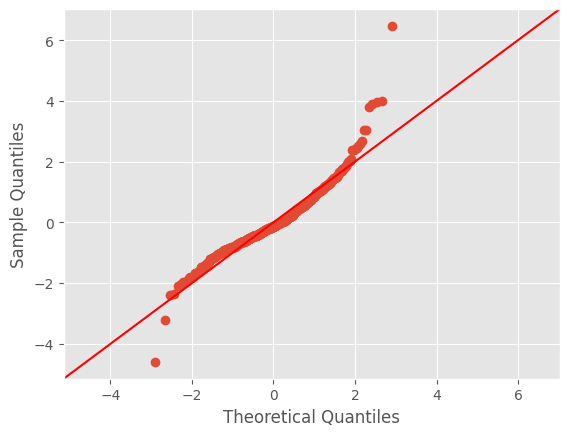

In [ ]:
# QQ Plot - Residuals are normally distributed
res = y_test - y_pred
sm.qqplot(res, fit=True, line="45");

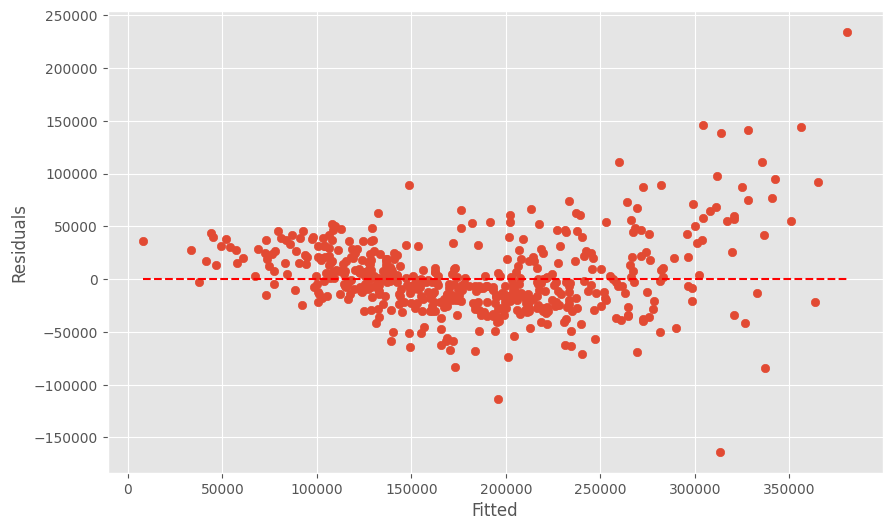

In [ ]:
# Residuals vs Fitted (Predicted) Values - Constant variance
#don't want to see patterns here
plt.figure(figsize = (10,6))
plt.scatter(y_pred, res)
plt.xlabel("Fitted")
plt.ylabel("Residuals")
plt.hlines(0, min(y_pred), max(y_pred), colors = 'red', linestyles = 'dashed') ;

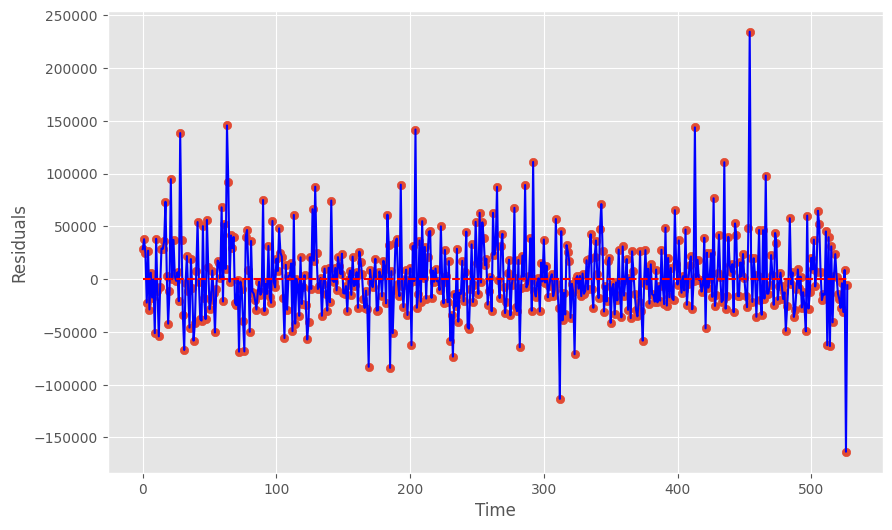

In [ ]:
# Residuals vs Time - indepedence
plt.figure(figsize = (10,6))
plt.scatter(range(len(res)), res)
plt.plot(range(len(res)), res, 'b')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.hlines(0, min(range(len(res))), max(range(len(res))), colors = 'red', linestyles = 'dashed')